In [1]:
from mave_calibration.initializations import kmeans_init,gmm_init
from mave_calibration.skew_normal import density_utils,fit
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [35]:
true_params = [
    [1.5, -2.5, 1.5],
    [-1, 3., 2]
]

prior_prob_pathogenicity = .25
true_weights = np.array([[.85, 0.15],
                         [0.3, .7]])
population_weights = prior_prob_pathogenicity * true_weights[0] + (1 - prior_prob_pathogenicity) * true_weights[1]
true_weights = np.concatenate([true_weights,population_weights.reshape(1,2)])
n_observations = [1000,1000,5000]

In [36]:
X = np.zeros((0,))
S = np.zeros((0, len(n_observations))).astype(bool)
for sample_num, (sample_size, sample_weights) in enumerate(zip(n_observations,true_weights)):
    x = np.concatenate([sps.skewnorm.rvs(a, loc, scale, size=int(round(sample_size * w))) for (a, loc, scale),w in zip(true_params, sample_weights)])
    s = np.zeros((len(x), len(n_observations))).astype(bool)
    s[:, sample_num] = 1
    X = np.concatenate([X, x])
    S = np.concatenate([S, s])

In [37]:
GMM_inits = []
KMeans_inits = []
from tqdm import trange
for repetition in trange(25):
    GMM_inits.append(gmm_init(X[S[:,2]],n_inits=10))
    KMeans_inits.append(kmeans_init(X[S[:,2]]))

100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


In [38]:
GMM_LLs = []
KMeans_LLs = []
XP = X[S[:,2]]
for initialization in GMM_inits:
    comp_weights = density_utils.component_posteriors(XP, initialization,[.5,.5]).mean(1)
    ll = np.log(density_utils.mixture_pdf(XP,  initialization, comp_weights)).sum() / len(X)
    GMM_LLs.append(ll)

for initialization in KMeans_inits:
    comp_weights = density_utils.component_posteriors(XP, initialization,[.5,.5]).mean(1)
    ll = np.log(density_utils.mixture_pdf(XP, initialization, comp_weights)).sum() / len(X)
    KMeans_LLs.append(ll)

Text(0, 0.5, 'Average Log likelihood')

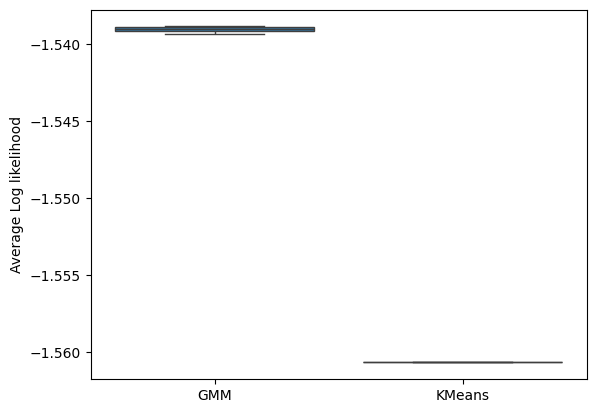

In [39]:
sns.boxplot(data={"GMM" : GMM_LLs,"KMeans" : KMeans_LLs})
plt.ylabel("Average Log likelihood")

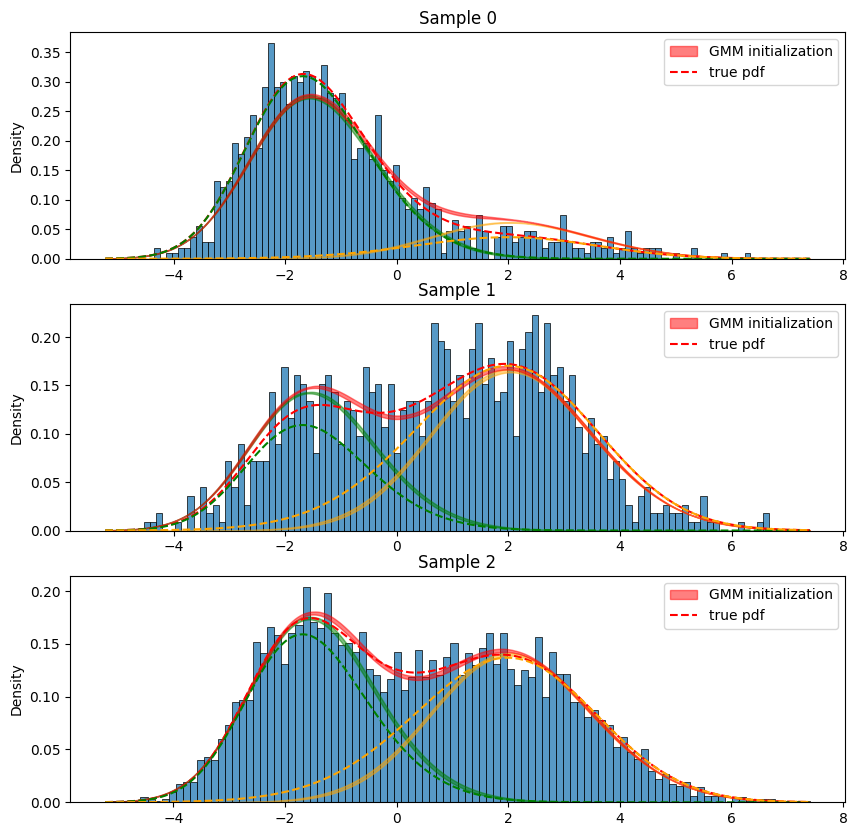

In [40]:
rng = np.arange(X.min(),X.max(),.01)
N_samples = len(n_observations)
fig,ax = plt.subplots(N_samples,1,figsize=(10,10))
for i in range(N_samples):
    Xc = X[S[:,i]]
    sns.histplot(Xc, bins=100, ax=ax[i],stat='density')
    ax[i].set_title(f"Sample {i}")

    GMM_sample_pdfs = []
    GMM_component_joint_pdfs = []
    for component_params in GMM_inits:
        comp_weights = density_utils.component_posteriors(Xc, component_params,[.5,.5]).mean(1)
        component_joint_pdfs = density_utils.joint_densities(rng, component_params, comp_weights)
        GMM_component_joint_pdfs.append(component_joint_pdfs)
        sample_pdf = component_joint_pdfs.sum(0)
        GMM_sample_pdfs.append(sample_pdf)
    GMM_sample_pdfs = np.stack(GMM_sample_pdfs)
    GMM_component_joint_pdfs = np.stack(GMM_component_joint_pdfs,axis=1)
    k0,k1 = np.percentile(GMM_component_joint_pdfs[0],[2.5,97.5],axis=0)
    ax[i].fill_between(rng,k0,k1,alpha=.5,color='green')
    k0,k1 = np.percentile(GMM_component_joint_pdfs[1],[2.5,97.5],axis=0)
    ax[i].fill_between(rng,k0,k1,alpha=.5,color='orange')
    y0,y1 = np.percentile(GMM_sample_pdfs,[2.5,97.5],axis=0)
    ax[i].fill_between(rng,y0,y1,alpha=.5,color='red', label='GMM initialization')

    ax[i].plot(rng, true_weights[i,0] * sps.skewnorm.pdf(rng, *true_params[0]) + \
                    true_weights[i,1] * sps.skewnorm.pdf(rng, *true_params[1]),
                    color='red',linestyle='--',label='true pdf')

    ax[i].plot(rng, true_weights[i,0] * sps.skewnorm.pdf(rng, *true_params[0]),color='green',linestyle='--')
    ax[i].plot(rng,true_weights[i,1] * sps.skewnorm.pdf(rng, *true_params[1]),color='orange',linestyle='--')
    ax[i].legend()